With the previous notebook we say how to recover the progression states of first a single specification and then a list of specifications. The automaton comprising of the computed state and the edges connecting the state is the specification MDP. In this notebool we learn how to visualize this MDP and define a reward function based on  a minimum regret formulation.

Lets first start by importing the synthetic and the dinner table domain data

In [1]:
from FormulaTools import *
from Progression import *
from Constants import *
from SpecificationFSMTools import *
import numpy as np

In [2]:
PathToDataFile = ''
SampleSignal = ImportSampleData(PathToDataFile)
TraceSlice = GetTraceSlice(SampleSignal,0)
Formulas, Prob = ImportCandidateFormulas()
idx = np.argsort(Prob)[::-1]
Formulas_synth = np.array(Formulas)[idx]
Probs_synth = np.array(Prob)[idx]
ProgressedFormulas_synth = np.array([ProgressSingleTimeStep(formula, TraceSlice) for formula in Formulas_synth])

Data = json.load(open('DinnerTable_OutputDist_Sampler4_Custom_30.json','r'))
Formulas, Probs = Data['support'],Data['probs']
#Sort the formulas as per the probabilities
idx = np.argsort(Probs)[::-1]
Formulas_dinner = np.array(Formulas)[idx]
Probs_dinner = np.array(Probs)[idx]

#Proposition data
Signal = ImportBSIData('DinnerTableData.json')
TraceSlice = GetTraceSlice(Signal, 0)
Conditions = [key for key in TraceSlice.keys() if 'P' in key]
for key in Conditions: TraceSlice[key] = True


#Progress every formula by a single time step
#ProgressedFormulas_dinner = np.array([ProgressSingleTimeStep(formula, TraceSlice) for formula in Formulas_dinner])
ProgressedFormulas_dinner = Formulas_dinner
#print('The number of formulas in the posterior is: ', len(ProgressedFormulas_dinner))

def ImportData(nFormula = 'all'):
    
    
    ProgressedFormulas = {'synth': ProgressedFormulas_synth, 'dinner': ProgressedFormulas_dinner}
    Probs = {'synth': Probs_synth, 'dinner': Probs_dinner}
    Formulas = {'synth': Formulas_synth, 'dinner': Formulas_dinner}

    progression_states = {}
    edges = {}
    terminal_states = {}
    Domain = {'synth': 'Synthetic Domain', 'dinner': 'Dinner Table Domain'}

    keys = ['synth', 'dinner']
    for key in keys:
        domain = Domain[key]
        print(f'Finding progression states for {domain} with {nFormula} formulas')
        if nFormula == 'all':
            progression_states[key], edges[key] = FindAllProgressions(ProgressedFormulas[key])
        else:
            nFormula = nFormula if nFormula <= len(ProgressedFormulas[key]) else len(ProgressedFormulas[key])
            progression_states[key], edges[key] = FindAllProgressions(ProgressedFormulas[key][0:nFormula])
        terminal_states[key] = FindTerminalStates(progression_states[key])
        print(f'Number of unique progressions in {domain}: ', len(progression_states[key]))
        print(f'Number of edges in {domain}: ', len(edges[key]))
        print(f'Number of terminal states in {domain}: ', len(terminal_states[key]),'\n')
    
    return progression_states, edges, terminal_states, Probs

Lets select the number of formulas we would like to include in them model for both the synthetic and the dinner table domain. Lets start with 5 formulas

In [3]:
NFormula = 50
progression_states, edges, terminal_states, probs = ImportData(NFormula)

Finding progression states for Synthetic Domain with 50 formulas
Number of unique progressions in Synthetic Domain:  79
Number of edges in Synthetic Domain:  610
Number of terminal states in Synthetic Domain:  19 

Finding progression states for Dinner Table Domain with 50 formulas
Number of unique progressions in Dinner Table Domain:  6612
Number of edges in Dinner Table Domain:  83263
Number of terminal states in Dinner Table Domain:  592 



Lets start with the synthetic domain. We use the higher order function `CreateReward_min_regret` to create a reward function consistent with the minimum regret formulation of the planning problem

In [5]:
Reward = {}
Reward['synth'] = CreateReward_min_regret(probs['synth'])

We can visualize what the transition structure of this specification set looks like using the `VisualizeProgressionStates` function

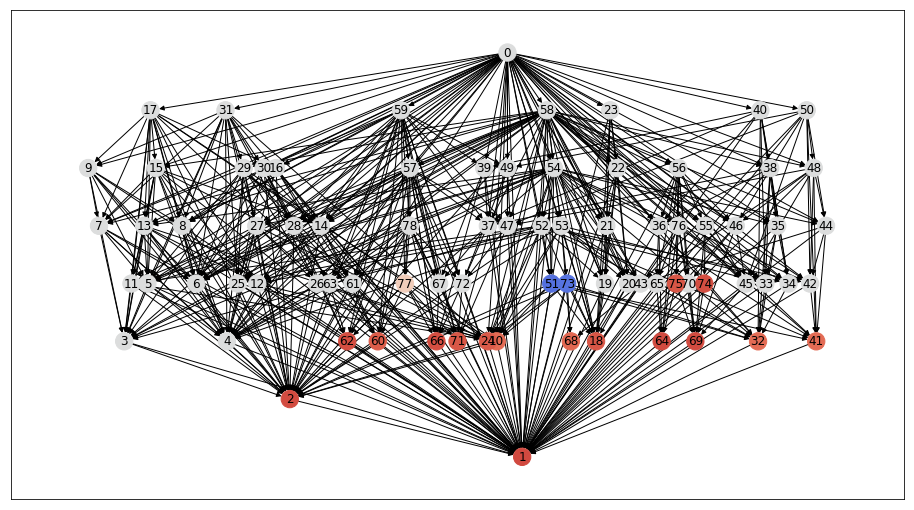

In [7]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16,9]

G, colors = VisualizeProgressionStates(progression_states['synth'], edges['synth'], Reward['synth'], terminal_states=terminal_states)

The colormap shows the single step reward accumulated in each stage. Red is low, blue is high. The reward is 0 in intermediate states and it is non-zero only in terminal states.

We can also plot which of the rewards is terminal and which is not terminal using the keyword argument `colormap = 'terminal'`

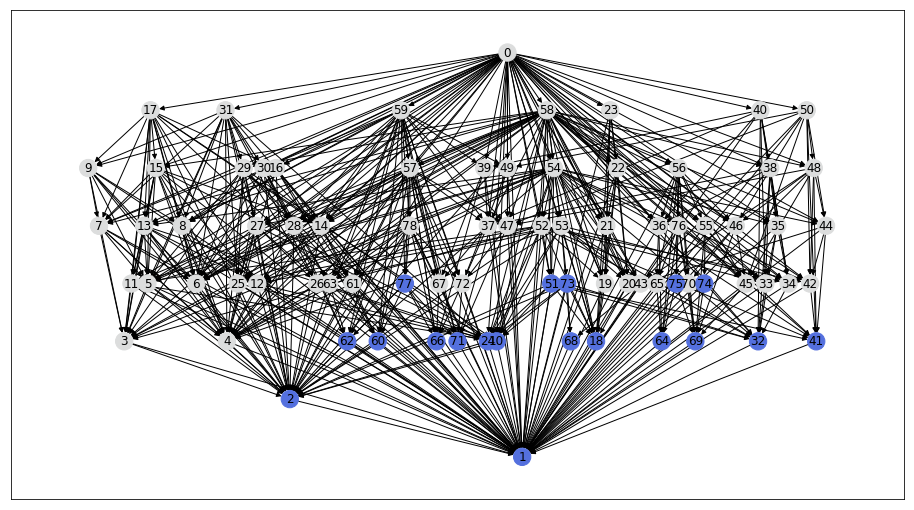

In [8]:
G,colors = VisualizeProgressionStates(progression_states['synth'], edges['synth'], Reward['synth'], terminal_states = terminal_states['synth'], colormap='terminal')

Now lets try this out for the dinner table domain. Note that this might take a long time to render the graph as there are many nodes.

In [9]:
Reward['dinner'] = CreateReward_min_regret(probs['dinner'])
#G,colors = VisualizeProgressionStates(progression_states['dinner'], edges['dinner'], Reward['dinner'], terminal_states = terminal_states['dinner'])

In [10]:
inverse_states = dict([(v,k) for (k,v) in progression_states['dinner'].items()])

<BarContainer object of 25 artists>

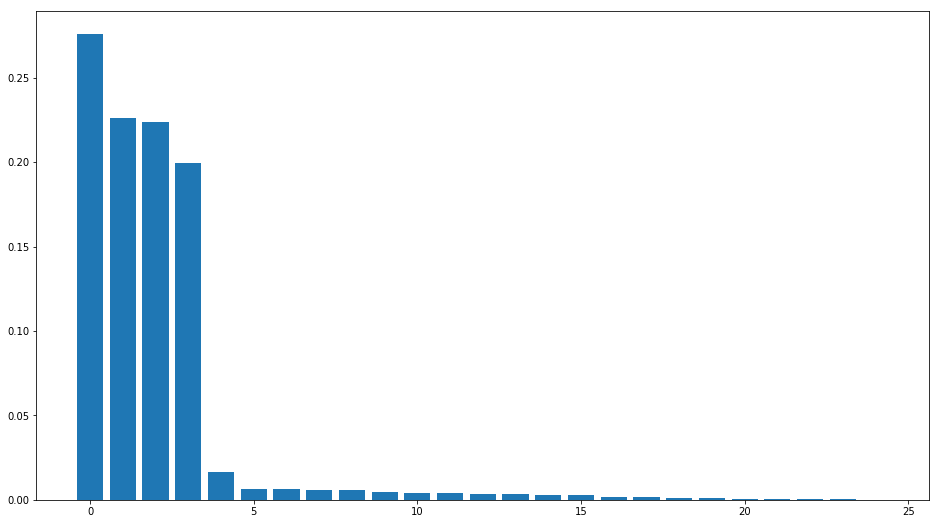

In [11]:
matplotlib.pyplot.bar(np.arange(len(probs['dinner'])),probs['dinner'])